# S-Learner
* Meta-Learnerの手法の一つ
* 一つのモデルのみで推論するのでS-Learner

In [2]:
import random
import numpy as np
from numpy.random import *
import matplotlib.pyplot as plt
import scipy.stats
from scipy.special import expit
import pandas as pd

#LightGBMのインポート
import lightgbm as lgbm

## データの用意

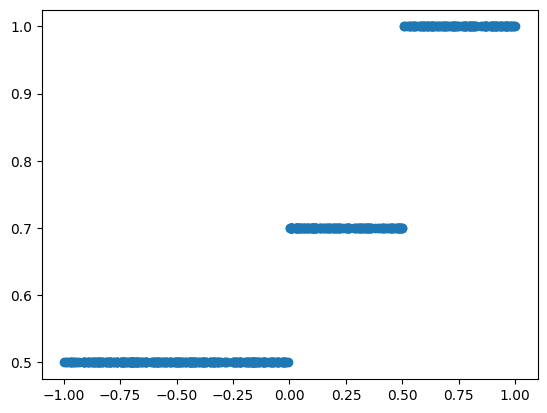

In [3]:
# データ数
num_data = 500

# 部下育成への熱心さ
x = np.random.uniform(low=-1, high=1, size=num_data)  # -1から1の一様乱数

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
e_z = randn(num_data)  # ノイズの生成
z_prob = expit(-5.0*x+5*e_z)
Z = np.array([])

# 上司が「上司向け：部下とのキャリア面談のポイント研修」に参加したかどうか
for i in range(num_data):
    Z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)

# 介入効果の非線形性：部下育成の熱心さxの値に応じて段階的に変化
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0

e_y = randn(num_data)
Y = 2.0 + t*Z + 0.3*x + 0.1*e_y 

# 介入効果を図で確認
plt.scatter(x, t, label="treatment-effect")

In [4]:
df = pd.DataFrame({'x': x,
                   'Z': Z,
                   't': t,
                   'Y': Y,
                   })

df.head()

,x,Z,t,Y
0,0.695951,0.0,1.0,2.260404
1,0.077758,0.0,0.7,2.167513
2,0.026823,1.0,0.7,2.807806
3,-0.235309,0.0,0.5,1.896311
4,0.033308,0.0,0.7,1.886472


## S-Learner

In [ ]:
params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse'
}


categorical_features = []



# 介入を受けていない集団のモデル
#df_0 = df[df.Z == 0.0]
x_train = df[["x","Z"]]
y_train = df[["Y"]]

#LightGBM用の訓練データセットを作成
lgb_train = lgbm.Dataset(x_train, y_train, categorical_feature=categorical_features, free_raw_data=False)


model = lgbm.train(params = params,
                        train_set = lgb_train)

## ATEを求める

In [7]:
# 処置が0と1の状態を作成する
X_0 = df[["x","Z"]]
X_0["Z"] = 0.0

X_1 = df[["x","Z"]]
X_1["Z"] = 1.0

# ATEの計算
ATE = (model.predict(X_1)-model.predict(X_0)).mean()
print("ATE：", ATE)

ATE： 0.677397482948454


/tmp/ipykernel_46569/1450545042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_0["Z"] = 0.0
/tmp/ipykernel_46569/1450545042.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_1["Z"] = 1.0


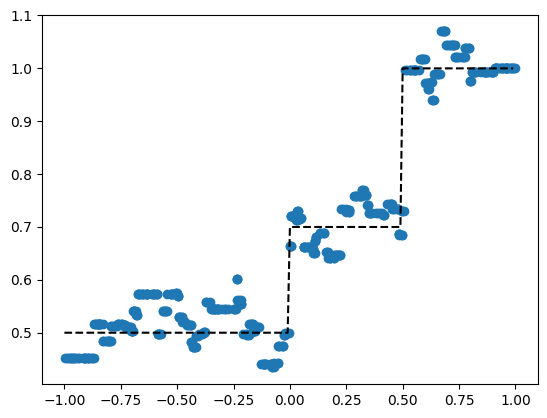

In [10]:
# 推定された処置効果を各人ごとに求めます
t_estimated = model.predict(X_1)-model.predict(X_0)
plt.scatter(df[["x"]], t_estimated,
            label="estimated_treatment-effect")


x_index = np.arange(-1, 1, 0.01)
t_ans = np.zeros(len(x_index))
for i in range(len(x_index)):
    if x_index[i] < 0:
        t_ans[i] = 0.5
    elif x_index[i] >= 0 and x_index[i] < 0.5:
        t_ans[i] = 0.7
    elif x_index[i] >= 0.5:
        t_ans[i] = 1.0
        

# 正解を描画
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')